In [2]:
import pandas as pd
import sys
sys.path.append('../py')
import db
import weighted
import inspect
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import scipy.stats as stats
import numpy as np
import math


In [3]:
from matplotlib.font_manager import _rebuild

_rebuild() #reload一下

In [9]:
conn=db.get_conn()
cities = "('北京','上海','深圳','杭州','广州','南京','成都','东莞','西安','武汉','天津','长沙','宁波','福州','大连','重庆','青岛','济南','合肥','长春','昆明','郑州','沈阳','哈尔滨')"
data_original=pd.read_sql(sql="select * from _201904 where monthly_salary>0 and monthly_salary<80000 and YEAR(publish_date)=2019 and MONTH(publish_date)=4 and city in "+cities, con=conn)
conn.close()

In [10]:
error_job_ids=['104660258','104142922','108434795','101357291','106253516','110368302','111391233','108665401','109277048'
                  ,'73857191','108584955','102824950','102824949','111391233','110884556']
data=data_original[~data_original.job_id.isin(error_job_ids)]

In [11]:
del data['publish_date']
del data['published_on_weekend']
del data['title']
del data['company_title']
del data['company_description']
del data['job_description']
del data['job_id']

In [12]:
#Common Functions
def get_sub_stats_by_col(data, col):
    categories=data[col].unique()
    salary_mean=[]
    salary_95_min=[]
    salary_95_max=[]
    salary_median=[]

    count=[]
    
    categorys_out=[]
    for category in categories:
        #print(feature)
        idata=data[data[col]==category]
        headcount=idata.headcount.sum()
        values = idata.monthly_salary.values
        weights = idata.headcount.values
        #print(str(headcount))
        if headcount==0:
            continue
        
        salary_mean.append(np.average(values, weights=weights))
        

        q = weighted.weighted_quantile(values,[0.025,0.5,0.975],weights)
        salary_95_min.append(q[0])
        salary_median.append(q[1])
        salary_95_max.append(q[2])
        count.append(idata.headcount.sum())
        categorys_out.append(category)
    sub_data=pd.DataFrame()
    sub_data[col]=[c for c in categorys_out]
    sub_data['salary_mean']=salary_mean
    sub_data['salary_95_min']=salary_95_min
    sub_data['salary_median']=salary_median
    sub_data['salary_95_max']=salary_95_max
    sub_data['head_count']=count
    sub_data['percentage']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='salary_mean', ascending=False)

    return sub_data

data_format={"percentage":"{:.2%}","salary_mean":"{:.0f}","salary_median":"{:.0f}","salary_95_min":"{:.0f}","salary_95_max":"{:.0f}"}

translate_dict={}


# 程序员工资

In [13]:
data_city=get_sub_stats_by_col(data,'city')
data_city.style.format(data_format)

,city,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
1,北京,17540,3750,15000,45000,23614,9.14%
2,上海,16009,5250,14583,35000,45725,17.71%
5,深圳,15898,5250,14000,37500,35573,13.78%
3,杭州,14602,3750,12500,30000,13896,5.38%
7,南京,13161,3750,12500,30000,14799,5.73%
4,广州,12969,3750,12500,30000,30371,11.76%
8,成都,11712,3033,11000,27500,11713,4.54%
18,东莞,11221,3750,10500,24000,2618,1.01%
0,武汉,11210,3750,10000,26000,15558,6.02%
23,济南,10689,3000,8000,37500,4255,1.65%


In [14]:
def describe(data_city, career):
    
    for index, row in data_city.iterrows():
        print("2019年4月{0}招收{1}{2}人。2019年4月{0}{1}平均工资{3:.0f}元，工资中位数{4:.0f}元，其中95%的人的工资介于{5:.0f}元到{6:.0f}元。\r\n".format(row[0], career, row[5], row[1], row[3], row[2], row[4]))


In [15]:
describe(data_city,'程序员')

2019年4月北京招收程序员23614人。2019年4月北京程序员平均工资17540元，工资中位数15000元，其中95%的人的工资介于3750元到45000元。

2019年4月上海招收程序员45725人。2019年4月上海程序员平均工资16009元，工资中位数14583元，其中95%的人的工资介于5250元到35000元。

2019年4月深圳招收程序员35573人。2019年4月深圳程序员平均工资15898元，工资中位数14000元，其中95%的人的工资介于5250元到37500元。

2019年4月杭州招收程序员13896人。2019年4月杭州程序员平均工资14602元，工资中位数12500元，其中95%的人的工资介于3750元到30000元。

2019年4月南京招收程序员14799人。2019年4月南京程序员平均工资13161元，工资中位数12500元，其中95%的人的工资介于3750元到30000元。

2019年4月广州招收程序员30371人。2019年4月广州程序员平均工资12969元，工资中位数12500元，其中95%的人的工资介于3750元到30000元。

2019年4月成都招收程序员11713人。2019年4月成都程序员平均工资11712元，工资中位数11000元，其中95%的人的工资介于3033元到27500元。

2019年4月东莞招收程序员2618人。2019年4月东莞程序员平均工资11221元，工资中位数10500元，其中95%的人的工资介于3750元到24000元。

2019年4月武汉招收程序员15558人。2019年4月武汉程序员平均工资11210元，工资中位数10000元，其中95%的人的工资介于3750元到26000元。

2019年4月济南招收程序员4255人。2019年4月济南程序员平均工资10689元，工资中位数8000元，其中95%的人的工资介于3000元到37500元。

2019年4月长沙招收程序员6182人。2019年4月长沙程序员平均工资10663元，工资中位数10000元，其中95%的人的工资介于3750元到22500元。

2019年4月西安招收程序员7680人。2019年4月西安程序员平均工资10632元，工资中位数10000元，其中95%的人的工资介于3750元到22500元。

2019年4月宁波

In [16]:
data_location = pd.read_csv('city_locations.csv')
data_location=data_location.set_index('city')

In [17]:
from mpl_toolkits.basemap import Basemap

In [18]:
def draw_map(data_city,headcount_scale, title):


    #cities = []
    scale = 5

    locations = [(116.407526, 39.90403),(120, 30)]
    #fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams['figure.figsize'] = [13, 13]
    #plt.figure(figsize = (10,5))
    fig, ax = plt.subplots()
    fig.title=title
    fig.figsize=(10,5)
    fig.dpi=80
    cn_map= Basemap(llcrnrlon=77, llcrnrlat=14, urcrnrlon=140, urcrnrlat=51, \
               projection='lcc', lat_1=33, lat_2=45, lon_0=100) # ‘lcc'将投影方式设置为兰伯特投影

    # load the shapefile, use the name 'states'
    cn_map.readshapefile(r'D:/data/basemap/gadm36_CHN_shp/gadm36_CHN_1', name='china', drawbounds=True, color='gray')
    cn_map.readshapefile(r'D:/data/basemap/gadm36_TWN_shp/gadm36_TWN_1', name='taiwan', drawbounds=True, color='gray')
    #geolocator = Nominatim(user_agent="my-application")



    salary_min=data_city.salary_mean.min()
    salary_max=data_city.salary_mean.max()
    salary_middle = (salary_min+salary_max)/2
    salary_scale=salary_max-salary_min

    for index, row in data_city.iterrows():
        city=row[0]
        
        longitude = data_location.loc[city,'longitude']
        latitude = data_location.loc[city,'latitude']
        salary=row[1]
        headcount=row[5]
        #color
        color_red=0
        color_green=0
        color_blue=0
        if salary>salary_middle:
            color_red = 255 #int((salary - salary_middle) / (salary_scale/2)*255)
            color_green = int((salary_max - salary) / (salary_scale/2)*255)
        else:
            color_blue = int((salary_middle - salary) / (salary_scale/2)*255)
            color_green = int((salary - salary_min) / (salary_scale/2)*255)
            color_red = int((salary - salary_min) / (salary_scale/2)*255)

        color = '#{:02x}{:02x}{:02x}'.format(color_red,color_green,color_blue)


        x, y = cn_map(longitude,latitude)
        cn_map.plot(x,y,marker='o',color=color,markersize=int(math.sqrt(headcount/headcount_scale))+8)
        #ax.annotate(city, (x,y), xytext=(5, 5), textcoords='offset points', fontsize=15)
        #"{}{:.0f}".format(city_cn, salary)
        #ax.text(x+5, y+5,city , fontweight='bold', fontsize=int(headcount/2500+12))
        fontsize=int(math.sqrt(headcount/headcount_scale))+13
        if city == '杭州':
            x=x-400000
            y=y+10000
        elif city=='广州':
            x=x-400000
            y=y+10000
        elif city=='合肥':
            x=x-300000
            y=y+10000
        elif city=='深圳':
            y=y-100000
        elif city=='南京':
            x=x-100000
        elif city=='天津':
            y=y-50000
        elif city=='上海':
            x=x+50000
        elif city=='武汉':
            y=y-50000

        ax.text(x, y, "{}{:.0f}k".format(city, np.round(salary/1000)), fontweight='bold', fontsize=fontsize, bbox={'facecolor':color, 'alpha':0.3, 'pad':0})
    ax.text(2053805, 1077845, "https://github.com/juwikuang/china_job_survey".format(city, np.round(salary/1000)), fontweight='bold',color='#999999', fontsize=20, bbox={'facecolor':'#eeeeee', 'alpha':0.4, 'pad':0})    
    ax.text(205805, 107845, "https://github.com/juwikuang/china_job_survey".format(city, np.round(salary/1000)), fontweight='bold',color='#999999', fontsize=20, bbox={'facecolor':'#eeeeee', 'alpha':0.4, 'pad':0})    
    ax.text(805805, 4007845, title.format(city, np.round(salary/1000)), fontweight='bold',color='#111111', fontsize=25)    
    ax.text(805805, 3807845, "（城市大小代表招聘数量，颜色代表工资，红色最高，黄色次之，蓝最少）", fontweight='bold',color='#111111', fontsize=13)    
    #cn_map.drawcoastlines() #绘制海岸线
    #cn_map.drawcountries(linewidth=1.5) #绘制国家边界线
    plt.show()


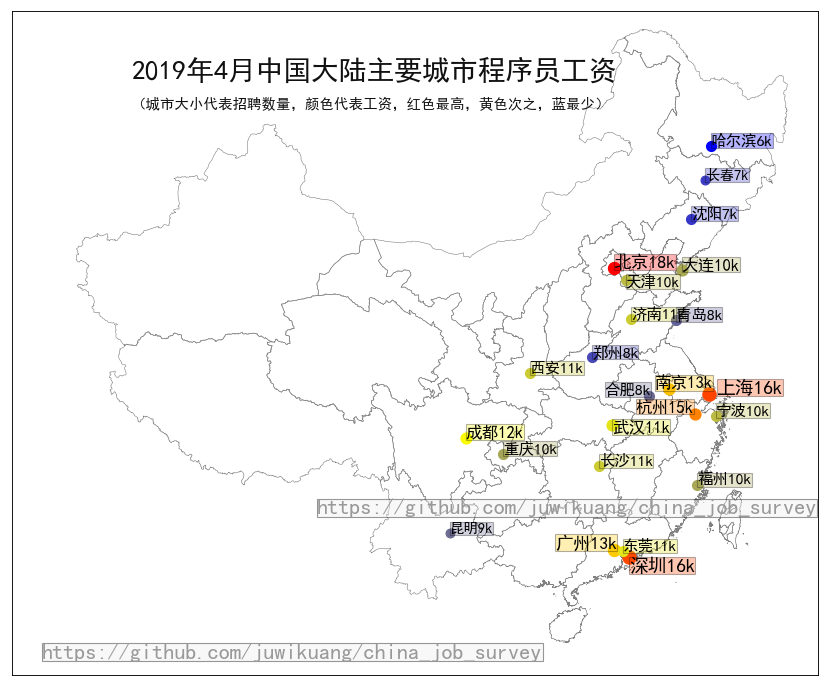

In [19]:
draw_map(data_city,2000,'2019年4月中国大陆主要城市程序员工资')

# 算法工程师

In [50]:
data_city_algorithm=get_sub_stats_by_col(data[data.career=='算法工程师'],'city')
data_city_algorithm.city=data_city_algorithm.city.map(translate_dict)
data_city_algorithm.style.format(data_format)

,city,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
0,北京,26617,5250,22500,65000,3475,25.06%
2,上海,21774,6324,20833,45000,3025,21.81%
5,深圳,21654,7000,20000,45000,1620,11.68%
3,杭州,19864,3658,18333,40000,1041,7.51%
4,广州,19469,5500,17702,40000,1024,7.38%
23,长春,18427,6250,11750,37500,41,0.30%
6,南京,17061,2545,15929,30844,606,4.37%
10,成都,16601,4162,15667,33917,606,4.37%
1,西安,15603,4500,15000,28398,305,2.20%
7,重庆,15601,3954,15000,33985,154,1.11%


In [51]:
describe(data_city_algorithm,'算法工程师')

2019年4月北京招收算法工程师3475人。2019年4月北京算法工程师平均工资26617元，工资中位数22500元，其中95%的人的工资介于5250元到65000元。

2019年4月上海招收算法工程师3025人。2019年4月上海算法工程师平均工资21774元，工资中位数20833元，其中95%的人的工资介于6324元到45000元。

2019年4月深圳招收算法工程师1620人。2019年4月深圳算法工程师平均工资21654元，工资中位数20000元，其中95%的人的工资介于7000元到45000元。

2019年4月杭州招收算法工程师1041人。2019年4月杭州算法工程师平均工资19864元，工资中位数18333元，其中95%的人的工资介于3658元到40000元。

2019年4月广州招收算法工程师1024人。2019年4月广州算法工程师平均工资19469元，工资中位数17702元，其中95%的人的工资介于5500元到40000元。

2019年4月长春招收算法工程师41人。2019年4月长春算法工程师平均工资18427元，工资中位数11750元，其中95%的人的工资介于6250元到37500元。

2019年4月南京招收算法工程师606人。2019年4月南京算法工程师平均工资17061元，工资中位数15929元，其中95%的人的工资介于2545元到30844元。

2019年4月成都招收算法工程师606人。2019年4月成都算法工程师平均工资16601元，工资中位数15667元，其中95%的人的工资介于4162元到33917元。

2019年4月西安招收算法工程师305人。2019年4月西安算法工程师平均工资15603元，工资中位数15000元，其中95%的人的工资介于4500元到28398元。

2019年4月重庆招收算法工程师154人。2019年4月重庆算法工程师平均工资15601元，工资中位数15000元，其中95%的人的工资介于3954元到33985元。

2019年4月东莞招收算法工程师73人。2019年4月东莞算法工程师平均工资15295元，工资中位数12500元，其中95%的人的工资介于7325元到27500元。

2019年4月武汉招收算法工程师613人。2019年4月武汉算法工程师平均工资14956元，工资中位数13000元，其中95

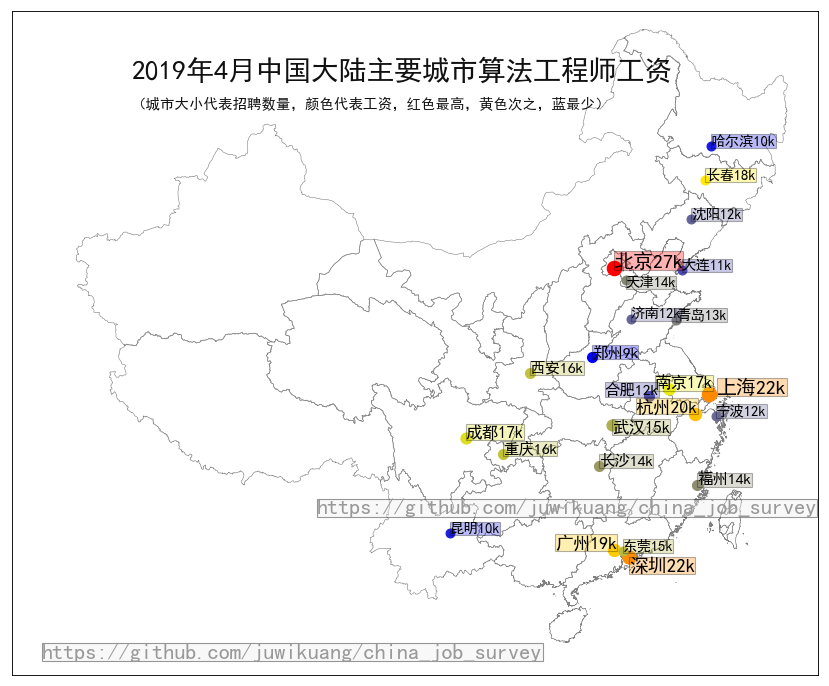

In [55]:
draw_map(data_city_algorithm,100,'2019年4月中国大陆主要城市算法工程师工资')

# 系统架构师

In [17]:
data_city_architect=get_sub_stats_by_col(data[data.career=='系统架构师'],'city')
data_city_architect.city=data_city_architect.city.map(translate_dict)
data_city_architect.style.format(data_format)

,city,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
7,深圳,23056,7867,22500,47833,832,11.28%
0,上海,22811,7000,22500,45000,1639,22.21%
6,北京,22655,5250,20000,45833,1560,21.14%
5,杭州,22034,5250,22500,40000,392,5.31%
20,青岛,20250,11500,21667,37917,30,0.41%
3,西安,19833,3443,20000,37500,123,1.67%
12,成都,19234,5062,17821,40982,345,4.68%
4,南京,18885,4903,17500,37500,223,3.02%
21,济南,18718,5892,16750,40000,62,0.84%
2,广州,17612,5250,16750,35167,808,10.95%


In [18]:
describe(data_city_architect,'系统架构师')

2019年4月深圳招收系统架构师832人。2019年4月深圳系统架构师平均工资23056元，工资中位数22500元，其中95%的人的工资介于7867元到47833元。

2019年4月上海招收系统架构师1639人。2019年4月上海系统架构师平均工资22811元，工资中位数22500元，其中95%的人的工资介于7000元到45000元。

2019年4月北京招收系统架构师1560人。2019年4月北京系统架构师平均工资22655元，工资中位数20000元，其中95%的人的工资介于5250元到45833元。

2019年4月杭州招收系统架构师392人。2019年4月杭州系统架构师平均工资22034元，工资中位数22500元，其中95%的人的工资介于5250元到40000元。

2019年4月青岛招收系统架构师30人。2019年4月青岛系统架构师平均工资20250元，工资中位数21667元，其中95%的人的工资介于11500元到37917元。

2019年4月西安招收系统架构师123人。2019年4月西安系统架构师平均工资19833元，工资中位数20000元，其中95%的人的工资介于3443元到37500元。

2019年4月成都招收系统架构师345人。2019年4月成都系统架构师平均工资19234元，工资中位数17821元，其中95%的人的工资介于5062元到40982元。

2019年4月南京招收系统架构师223人。2019年4月南京系统架构师平均工资18885元，工资中位数17500元，其中95%的人的工资介于4903元到37500元。

2019年4月济南招收系统架构师62人。2019年4月济南系统架构师平均工资18718元，工资中位数16750元，其中95%的人的工资介于5892元到40000元。

2019年4月广州招收系统架构师808人。2019年4月广州系统架构师平均工资17612元，工资中位数16750元，其中95%的人的工资介于5250元到35167元。

2019年4月长沙招收系统架构师146人。2019年4月长沙系统架构师平均工资16534元，工资中位数15000元，其中95%的人的工资介于6692元到45000元。

2019年4月福州招收系统架构师48人。2019年4月福州系统架构师平均工资16321元，工资中位数15167元，其中95%的人

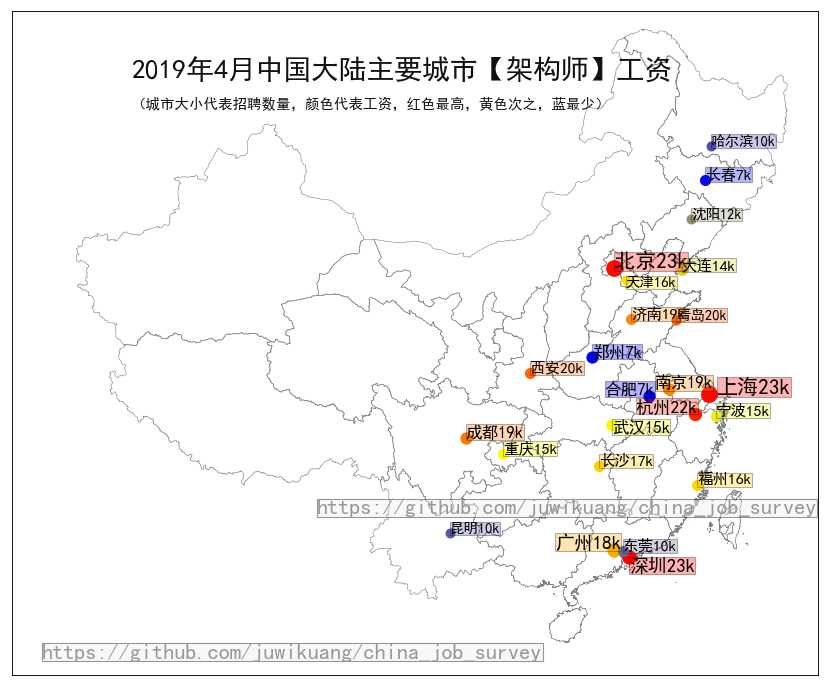

In [59]:
draw_map(data_city_architect,40,'2019年4月中国大陆主要城市【架构师】工资')

# 生物信息工程师

In [20]:
data_bio=get_sub_stats_by_col(data[data.career=='生物信息工程师'],'city')
data_bio.city=data_bio.city.map(translate_dict)
data_bio.style.format(data_format)

,city,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
3,上海,11714,8000,10800,17500,7,12.73%
4,长春,11500,11500,11500,11500,5,9.09%
0,深圳,10794,4500,11100,22500,34,61.82%
1,北京,8000,8000,8000,8000,6,10.91%
2,杭州,8000,8000,8000,8000,3,5.45%


In [21]:
describe(data_bio,'生物信息工程师')

2019年4月上海招收生物信息工程师7人。2019年4月上海生物信息工程师平均工资11714元，工资中位数10800元，其中95%的人的工资介于8000元到17500元。

2019年4月长春招收生物信息工程师5人。2019年4月长春生物信息工程师平均工资11500元，工资中位数11500元，其中95%的人的工资介于11500元到11500元。

2019年4月深圳招收生物信息工程师34人。2019年4月深圳生物信息工程师平均工资10794元，工资中位数11100元，其中95%的人的工资介于4500元到22500元。

2019年4月北京招收生物信息工程师6人。2019年4月北京生物信息工程师平均工资8000元，工资中位数8000元，其中95%的人的工资介于8000元到8000元。

2019年4月杭州招收生物信息工程师3人。2019年4月杭州生物信息工程师平均工资8000元，工资中位数8000元，其中95%的人的工资介于8000元到8000元。



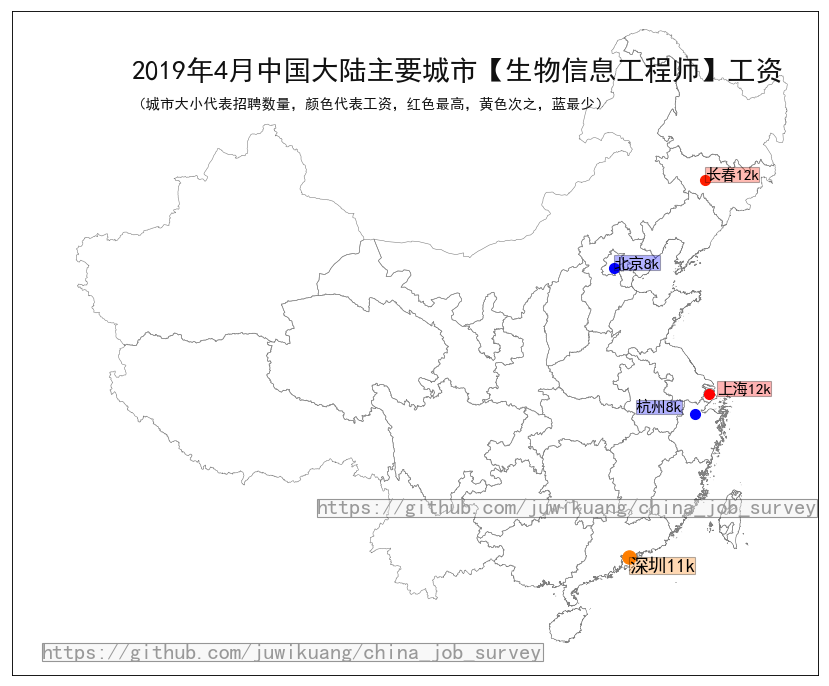

In [63]:
draw_map(data_bio,2,'2019年4月中国大陆主要城市【生物信息工程师】工资')

# 爬虫工程师

In [26]:
data_spider=get_sub_stats_by_col(data[data.career=='爬虫工程师'],'city')

data_spider.city=data_spider.city.map(translate_dict)
data_spider=data_spider[data_spider.head_count>10]
data_spider.style.format(data_format)

,city,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
6,广州,17742,2500,15000,37500,31,10.33%
4,上海,15750,2700,15000,30125,78,26.00%
9,深圳,15469,11000,13667,24000,35,11.67%
3,南京,14550,9000,13571,20000,20,6.67%
1,北京,14157,2170,12500,37438,61,20.33%
5,成都,13664,3750,13571,22500,29,9.67%
10,杭州,13515,3750,15000,17500,11,3.67%


In [27]:
describe(data_spider, '爬虫工程师')

2019年4月广州招收爬虫工程师31人。2019年4月广州爬虫工程师平均工资17742元，工资中位数15000元，其中95%的人的工资介于2500元到37500元。

2019年4月上海招收爬虫工程师78人。2019年4月上海爬虫工程师平均工资15750元，工资中位数15000元，其中95%的人的工资介于2700元到30125元。

2019年4月深圳招收爬虫工程师35人。2019年4月深圳爬虫工程师平均工资15469元，工资中位数13667元，其中95%的人的工资介于11000元到24000元。

2019年4月南京招收爬虫工程师20人。2019年4月南京爬虫工程师平均工资14550元，工资中位数13571元，其中95%的人的工资介于9000元到20000元。

2019年4月北京招收爬虫工程师61人。2019年4月北京爬虫工程师平均工资14157元，工资中位数12500元，其中95%的人的工资介于2170元到37438元。

2019年4月成都招收爬虫工程师29人。2019年4月成都爬虫工程师平均工资13664元，工资中位数13571元，其中95%的人的工资介于3750元到22500元。

2019年4月杭州招收爬虫工程师11人。2019年4月杭州爬虫工程师平均工资13515元，工资中位数15000元，其中95%的人的工资介于3750元到17500元。



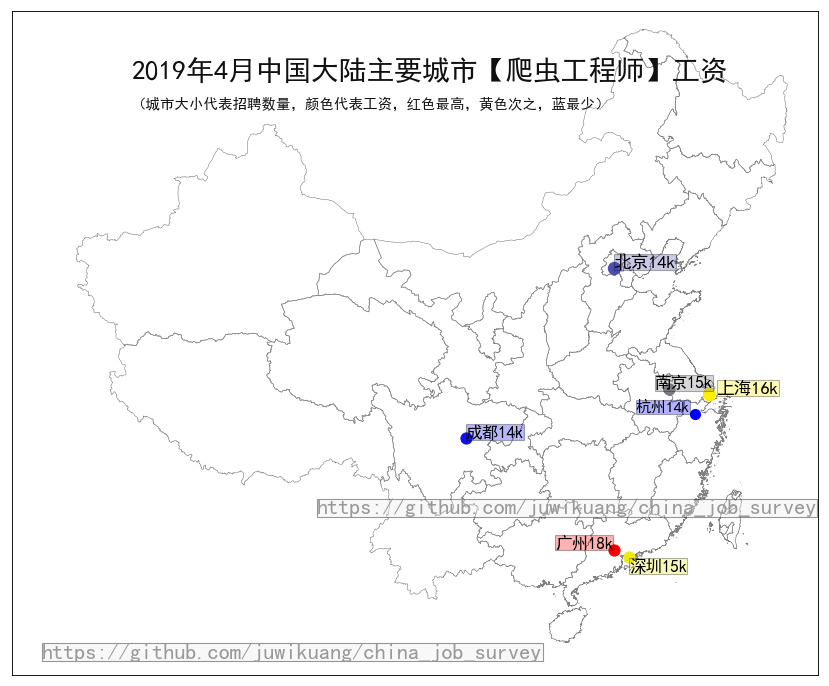

In [66]:
draw_map(data_spider,5,'2019年4月中国大陆主要城市【爬虫工程师】工资')

# Java程序员

In [29]:
data_java=get_sub_stats_by_col(data[(data.pl_java==1)],'city')
data_java.city=data_java.city.map(translate_dict)
data_java.style.format(data_format)

,city,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
0,上海,16109,5250,15000,33333,14266,19.52%
6,深圳,15852,5250,14000,35000,8147,11.15%
2,北京,15636,2500,12500,40000,13555,18.55%
1,杭州,15208,3750,13000,35000,4093,5.60%
9,天津,13411,4862,12500,30000,538,0.74%
7,广州,13188,3750,12500,30000,6831,9.35%
10,成都,12914,3942,12000,30000,3097,4.24%
3,南京,12291,4827,12000,30000,4691,6.42%
16,东莞,11809,4928,10500,24666,454,0.62%
11,西安,11386,3750,10347,30000,1860,2.55%


In [30]:
describe(data_java, 'Java程序员')

2019年4月上海招收Java程序员14266人。2019年4月上海Java程序员平均工资16109元，工资中位数15000元，其中95%的人的工资介于5250元到33333元。

2019年4月深圳招收Java程序员8147人。2019年4月深圳Java程序员平均工资15852元，工资中位数14000元，其中95%的人的工资介于5250元到35000元。

2019年4月北京招收Java程序员13555人。2019年4月北京Java程序员平均工资15636元，工资中位数12500元，其中95%的人的工资介于2500元到40000元。

2019年4月杭州招收Java程序员4093人。2019年4月杭州Java程序员平均工资15208元，工资中位数13000元，其中95%的人的工资介于3750元到35000元。

2019年4月天津招收Java程序员538人。2019年4月天津Java程序员平均工资13411元，工资中位数12500元，其中95%的人的工资介于4862元到30000元。

2019年4月广州招收Java程序员6831人。2019年4月广州Java程序员平均工资13188元，工资中位数12500元，其中95%的人的工资介于3750元到30000元。

2019年4月成都招收Java程序员3097人。2019年4月成都Java程序员平均工资12914元，工资中位数12000元，其中95%的人的工资介于3942元到30000元。

2019年4月南京招收Java程序员4691人。2019年4月南京Java程序员平均工资12291元，工资中位数12000元，其中95%的人的工资介于4827元到30000元。

2019年4月东莞招收Java程序员454人。2019年4月东莞Java程序员平均工资11809元，工资中位数10500元，其中95%的人的工资介于4928元到24666元。

2019年4月西安招收Java程序员1860人。2019年4月西安Java程序员平均工资11386元，工资中位数10347元，其中95%的人的工资介于3750元到30000元。

2019年4月宁波招收Java程序员484人。2019年4月宁波Java程序员平均工资11183元，工资中位数9500元，其中95%的人的工资介于3750元到25000元。

2019年4月武汉招收J

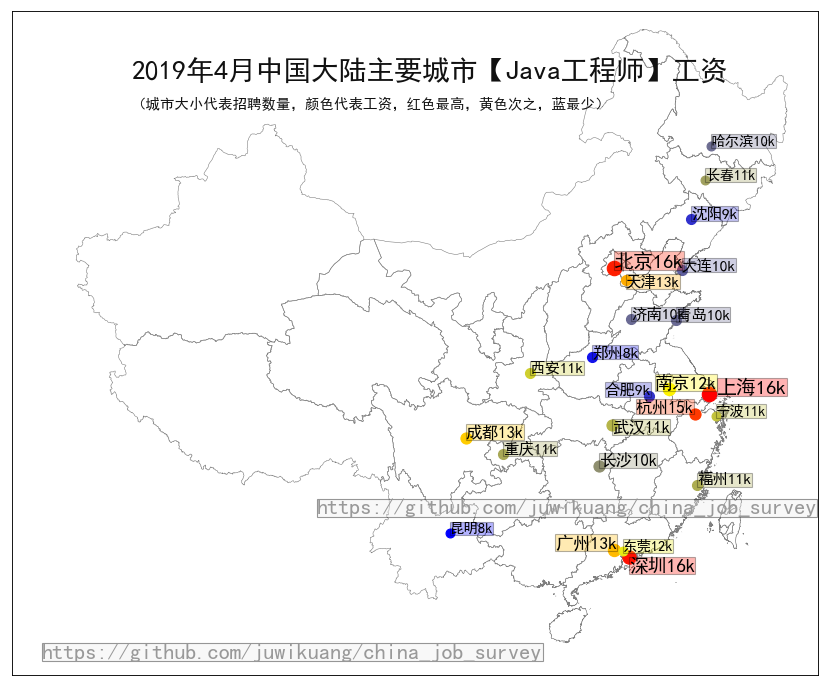

In [68]:
draw_map(data_java, 500, '2019年4月中国大陆主要城市【Java工程师】工资')

# Python程序员

In [32]:
data_python=get_sub_stats_by_col(data[(data.pl_python==1)],'city')
data_python.city=data_python.city.map(translate_dict)
data_python.style.format(data_format)

,city,salary_mean,salary_95_min,salary_median,salary_95_max,head_count,percentage
0,北京,20852,3750,17500,52982,4233,23.71%
3,上海,20553,5504,20000,45000,4061,22.75%
2,深圳,19081,6700,17500,37667,1892,10.60%
4,杭州,18524,2575,16000,43813,1118,6.26%
22,长春,18139,6500,13286,35000,18,0.10%
20,天津,17740,8567,15694,30000,128,0.72%
1,广州,17448,5431,15000,37500,1558,8.73%
7,南京,16592,3349,15000,30000,907,5.08%
15,西安,15691,3019,15000,30000,404,2.26%
5,成都,15226,3750,13500,32278,896,5.02%


In [33]:
describe(data_python, 'Python程序员')

2019年4月北京招收Python程序员4233人。2019年4月北京Python程序员平均工资20852元，工资中位数17500元，其中95%的人的工资介于3750元到52982元。

2019年4月上海招收Python程序员4061人。2019年4月上海Python程序员平均工资20553元，工资中位数20000元，其中95%的人的工资介于5504元到45000元。

2019年4月深圳招收Python程序员1892人。2019年4月深圳Python程序员平均工资19081元，工资中位数17500元，其中95%的人的工资介于6700元到37667元。

2019年4月杭州招收Python程序员1118人。2019年4月杭州Python程序员平均工资18524元，工资中位数16000元，其中95%的人的工资介于2575元到43813元。

2019年4月长春招收Python程序员18人。2019年4月长春Python程序员平均工资18139元，工资中位数13286元，其中95%的人的工资介于6500元到35000元。

2019年4月天津招收Python程序员128人。2019年4月天津Python程序员平均工资17740元，工资中位数15694元，其中95%的人的工资介于8567元到30000元。

2019年4月广州招收Python程序员1558人。2019年4月广州Python程序员平均工资17448元，工资中位数15000元，其中95%的人的工资介于5431元到37500元。

2019年4月南京招收Python程序员907人。2019年4月南京Python程序员平均工资16592元，工资中位数15000元，其中95%的人的工资介于3349元到30000元。

2019年4月西安招收Python程序员404人。2019年4月西安Python程序员平均工资15691元，工资中位数15000元，其中95%的人的工资介于3019元到30000元。

2019年4月成都招收Python程序员896人。2019年4月成都Python程序员平均工资15226元，工资中位数13500元，其中95%的人的工资介于3750元到32278元。

2019年4月福州招收Python程序员262人。2019年4月福州Python程序员平均工资15135元，工资中位数12500元，

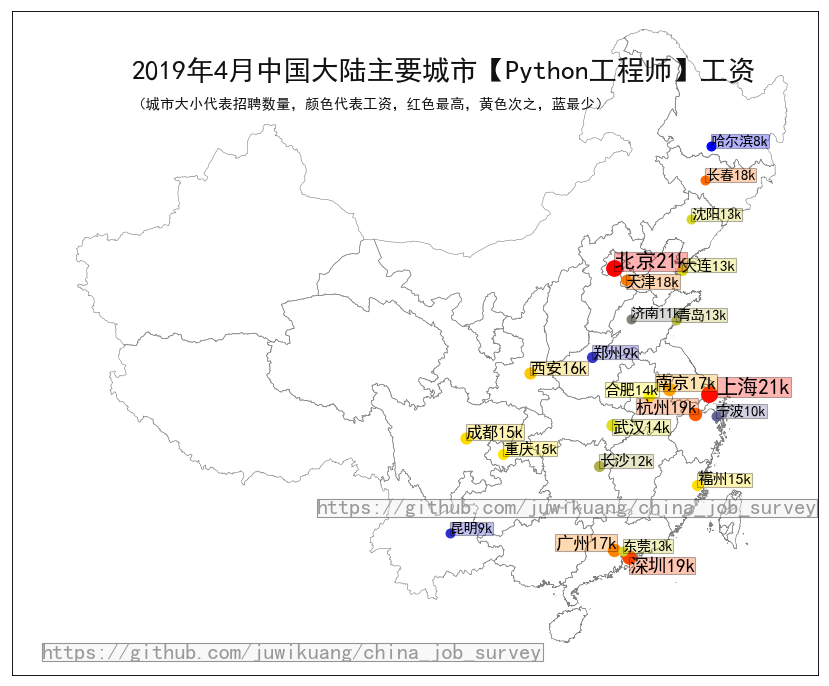

In [70]:
draw_map(data_python, 100,  '2019年4月中国大陆主要城市【Python工程师】工资')